In [14]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [25]:
import abc
from collections import defaultdict
import json
from IPython.display import clear_output
from itertools import chain
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from pathlib import Path
import pickle
import tensorflow as tf
import tf_utilities as tfu
from tqdm.auto import tqdm
from typing import Iterable, Generator, Optional
import time
import wandb

from dnadb.datasets import Greengenes, Silva
from dnadb import dna, fasta, sample, taxonomy

from deepdna.data.dataset import Dataset
from deepdna.data.tokenizers import AbstractTaxonomyTokenizer, TopDownTaxonomyTokenizer
from deepdna.nn.models import custom_model, dnabert, load_model, taxonomy as tax_models
from deepdna.nn.utils import encapsulate_model
from deepdna.nn import layers, functional, utils

In [16]:
tfu.devices.select_gpu(0)

([PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')],
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

## Dataset

In [4]:
dataset = Dataset("/home/dwl2x/work/Datasets/Silva2/0")
train_fastas = tuple(map(sample.load_fasta, dataset.fasta_dbs(Dataset.Split.Train)))
train_tax = tuple(map(taxonomy.TaxonomyDb, dataset.taxonomy_dbs(Dataset.Split.Train)))
test_fastas = tuple(map(sample.load_fasta, dataset.fasta_dbs(Dataset.Split.Test)))
test_tax = tuple(map(taxonomy.TaxonomyDb, dataset.taxonomy_dbs(Dataset.Split.Test)))

In [5]:
for label in test_tax[0]:
    assert train_tax[0].contains_label(label)

In [6]:
tokenizer = TopDownTaxonomyTokenizer(depth=6)
for db in train_tax:
    tokenizer.add_labels(db)
tokenizer.build()

In [5]:
from deepdna.data.samplers import SampleSampler, SequenceSampler
from deepdna.nn.data_generators import _encode_sequences, BatchGenerator
from typing import Any, cast

class SequenceTaxonomyGenerator(BatchGenerator):
    def __init__(
        self,
        fasta_taxonomy_pairs: Iterable[tuple[sample.FastaSample, taxonomy.TaxonomyDb]],
        sequence_length: int,
        taxonomy_tokenizer: AbstractTaxonomyTokenizer,
        kmer: int = 1,
        subsample_size: int|None = None,
        batch_size: int = 32,
        batches_per_epoch: int = 100,
        augment_slide: bool = True,
        augment_ambiguous_bases: bool = True,
        balance: bool = False,
        shuffle: bool = True,
        rng: np.random.Generator = np.random.default_rng()
    ):
        super().__init__(
            batch_size=batch_size,
            batches_per_epoch=batches_per_epoch,
            shuffle=shuffle,
            rng=rng
        )
        fasta_samples, taxonomy_dbs = zip(*fasta_taxonomy_pairs)
        self.sample_sampler = SampleSampler(cast(tuple[sample.FastaSample, ...], fasta_samples))
        self.sequence_sampler = SequenceSampler(sequence_length, augment_slide)
        self.taxonomy_dbs: tuple[taxonomy.TaxonomyDb, ...] = cast(Any, taxonomy_dbs)
        self.kmer = kmer
        self.taxonomy_tokenizer = taxonomy_tokenizer
        self.subsample_size = subsample_size
        self.augment_ambiguous_bases = augment_ambiguous_bases
        self.balance = balance

    @property
    def sequence_length(self) -> int:
        return self.sequence_sampler.sequence_length

    def generate_batch(
        self,
        rng: np.random.Generator
    ) -> tuple[npt.NDArray[np.int32], npt.NDArray[np.int32]]:
        subsample_size = self.subsample_size or 1
        sequences = np.empty((self.batch_size, subsample_size), dtype=f"<U{self.sequence_length}")
        sample_ids = np.empty(self.batch_size, dtype=np.int32)
        sequence_ids = [None] * self.batch_size
        label_ids = np.empty((self.batch_size, subsample_size, self.taxonomy_tokenizer.depth), dtype=np.int32)
        samples = self.sample_sampler.sample_with_ids(self.batch_size, self.balance, rng)
        for i, (sample_id, sample) in enumerate(samples):
            tax_db = self.taxonomy_dbs[sample_id]
            sequence_info = tuple(self.sequence_sampler.sample_with_ids(sample, subsample_size, rng))
            sequence_ids[i], sequences[i] = zip(*sequence_info)
            sample_ids[i] = sample_id
            label_ids[i] = [self.taxonomy_tokenizer.tokenize_label(tax_db.fasta_id_to_label(fasta_id)) for fasta_id in sequence_ids[i]]
        sequences = _encode_sequences(sequences, self.augment_ambiguous_bases, self.rng)
        if self.subsample_size is None:
            sequences = np.squeeze(sequences, axis=1)
            label_ids = np.squeeze(label_ids, axis=1)
        sequences = sequences.astype(np.int32)
        if self.kmer > 1:
            sequences = dna.encode_kmers(sequences, self.kmer, not self.augment_ambiguous_bases).astype(np.int32) # type: ignore
        return sample_ids, sequence_ids, sequences, tuple(label_ids.T)[-1]

    def reduce_batch(self, batch):
        # remove sample IDs and sequence IDs
        return batch[2:]

## Model

In [23]:
# api = wandb.Api()
run = wandb.init(project="dnabert-taxonomy", name="topdown 64d-150l")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sirdavidludwig. Use `wandb login --relogin` to force relogin


In [24]:
# path = api.artifact("sirdavidludwig/dnabert-pretrain/dnabert-pretrain-silva-64:v3").download()
path = run.use_artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-walker-abund-128d-250l:v3").download()
dnabert_model = load_model(path).base

wandb:   4 of 4 files downloaded.  


In [25]:
encoder = dnabert.DnaBertEncoderModel(dnabert_model, 256)
model = tax_models.TopDownTaxonomyClassificationModel(encoder, tokenizer)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

In [7]:
common_args = dict(
    sequence_length = 150,
    kmer = 3,
    taxonomy_tokenizer = model.taxonomy_tokenizer,
    subsample_size=None,
    batch_size = 256,
)

train_data = SequenceTaxonomyGenerator(
    zip(train_fastas, train_tax),
    batches_per_epoch=100,
    **common_args)
test_data = SequenceTaxonomyGenerator(
    zip(test_fastas, test_tax),
    batches_per_epoch=20,
    shuffle=False,
    **common_args)

In [ ]:
model.tax

In [27]:
wandb_callback = wandb.keras.WandbCallback(save_model=False)
wandb_callback.save_model_as_artifact = False
checkpoint = tf.keras.callbacks.ModelCheckpoint("logs/models/dnabert_taxonomy_topdown", save_best=False)

In [ ]:
model.fit(train_data, validation_data=test_data, epochs=4000, initial_epoch=3500, callbacks=[wandb_callback, checkpoint])

Epoch 3501/4000
100/100 [==============================] - ETA: 0s - loss: 0.9723 - sparse_categorical_accuracy: 0.7764

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_topdown/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_topdown/assets


100/100 [==============================] - 46s 459ms/step - loss: 0.9723 - sparse_categorical_accuracy: 0.7764 - val_loss: 0.7770 - val_sparse_categorical_accuracy: 0.8207
Epoch 3502/4000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


 80/100 [=======================>......] - ETA: 6s - loss: 0.9537 - sparse_categorical_accuracy: 0.7813

In [41]:
model.save("logs/models/dnabert_taxonomy_topdown")

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_topdown/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_topdown/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [42]:
a = wandb.Artifact(name="dnabert-taxonomy-topdown-64d-150l", type="model")

In [43]:
a.add_dir("logs/models/dnabert_taxonomy_topdown")

wandb: Adding directory to artifact (./logs/models/dnabert_taxonomy_topdown)... Done. 0.1s


In [44]:
run.log_artifact(a)

<Artifact dnabert-taxonomy-topdown-64d-150l>

In [45]:
run.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_sparse_categorical_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
best_epoch,3996
best_val_loss,0.69509
epoch,3999
loss,0.93143
sparse_categorical_accuracy,0.78461
val_loss,0.82545


In [8]:
y_pred = model.predictive_model.predict(test_data)

20/20 [==============================] - 3s 79ms/step


2023-09-13 19:14:34.000933: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 226713600 exceeds 10% of free system memory.


### Direct Mapping to Taxons

In [9]:
label_ids = []
for rank in y_pred:
    label_ids.append(np.argmax(rank, axis=1))
label_ids = np.array(label_ids).T
label_ids.shape

(5120, 6)

In [10]:
taxonomy.join_taxonomy(model.taxonomy_tokenizer.id_to_taxons_map[-1][test_data[0][1][0]])

'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacterales; f__Pasteurellaceae; g__Haemophilus'

In [11]:
labels_true = []
for token in np.concatenate([np.array(batch[1]).T for batch in test_data], axis=0):
    labels_true.append(taxonomy.join_taxonomy(tuple(model.taxonomy_tokenizer.id_to_taxons_map[-1][token])))
len(labels_true)

5120

In [110]:
labels_pred = model.predictions_to_labels(y_pred[-1])

In [111]:
correct = 0
for y_p, y_t in zip(labels_true, labels_pred):
    correct += y_p == y_t
correct

4182

In [112]:
correct/len(labels_true)

0.816796875

### Constrain Taxon Selection using Tree

In [79]:
labels_true = []
for token in np.concatenate([np.array(batch[1]).T for batch in test_data], axis=0):
    labels_true.append(taxonomy.join_taxonomy(tuple(model.taxonomy_tokenizer.id_to_taxons_map[-1][token])))
len(labels_true)

5120

In [80]:
n = len(y_pred[0])
labels_pred = []
for i in range(n):
    head = model.taxonomy_tokenizer.tree
    taxons = ()
    constrained_indices = np.array([model.taxonomy_tokenizer.taxons_to_id_map[taxons + (k,)] for k in head.keys()])
    for rank, rank_pred in enumerate(y_pred):
        taxon_id = (constrained_indices[np.argmax(rank_pred[i][constrained_indices])])
        taxon = model.taxonomy_tokenizer.id_to_taxons_map[rank][taxon_id][-1]
        taxons += (taxon,)
        if rank < model.taxonomy_tokenizer.depth:
            head = head[taxon]
            constrained_indices = np.array([model.taxonomy_tokenizer.taxons_to_id_map[taxons + (k,)] for k in head.keys()])
    labels_pred.append(taxonomy.join_taxonomy(taxons))
len(labels_pred)

5120

In [81]:
correct = 0
for y_p, y_t in zip(labels_true, labels_pred):
    correct += y_p == y_t
correct

587

In [38]:
correct/len(labels_true)

0.7498046875

## Synthetic Sample Evaluation

In [7]:
def taxons_to_label(tokenizer, y_pred):
    n = len(y_pred[0])
    labels_pred = []
    for i in range(n):
        head = tokenizer.tree
        constrained_indices = np.array([tokenizer.taxon_to_id_map[0][k] for k in head.keys()])
        taxons = []
        for rank, rank_pred in enumerate(y_pred):
            taxon_id = (constrained_indices[np.argmax(rank_pred[i][constrained_indices])])
            taxon = tokenizer.id_to_taxon_map[rank][taxon_id]
            taxons.append(taxon)
            if rank < tokenizer.depth:
                head = head[taxon]
                constrained_indices = np.array([tokenizer.taxon_to_id_map[rank+1][k] for k in head.keys()])
        labels_pred.append(taxonomy.join_taxonomy(taxons))
    return labels_pred

In [8]:
api = wandb.Api()
path = api.artifact("sirdavidludwig/dnabert-taxonomy/dnabert-taxonomy-topdown-64d-150l:latest").download()
model = load_model(path)

wandb:   4 of 4 files downloaded.  


In [8]:
model.classify(test_data)

20/20 [==============================] - 3s 79ms/step


2023-09-13 19:13:01.859482: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 226713600 exceeds 10% of free system memory.


array(['k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Moraxellaceae; g__Enhydrobacter',
       'k__Bacteria; p__Firmicutes; c__Bacilli; o__Staphylococcales; f__Staphylococcaceae; g__Staphylococcus',
       'k__Bacteria; p__Bacteroidota; c__Bacteroidia; o__Bacteroidales; f__SB-5; g__SB-5',
       ...,
       'k__Bacteria; p__Verrucomicrobiota; c__Verrucomicrobiae; o__Chthoniobacterales; f__01D2Z36; g__01D2Z36',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Marinobacteraceae; g__Marinobacter',
       'k__Bacteria; p__Verrucomicrobiota; c__Chlamydiae; o__Chlamydiales; f__Chlamydiaceae; g__Chlamydia'],
      dtype='<U190')

In [39]:
model_type = "Naive"

In [40]:
datasets = {
    "Nachusa": Dataset(f"/home/dwl2x/work/Datasets/Synthetic/Nachusa/{model_type}/test"),
    # "Hopland": Dataset(f"/home/dwl2x/work/Datasets/Synthetic/Hopland/{model_type}/test"),
    # "Wetland": Dataset(f"/home/dwl2x/work/Datasets/Synthetic/Wetland/{model_type}/test"),
    # "SFD": Dataset(f"/home/dwl2x/work/Datasets/Synthetic/SFD/{model_type}/test")
}

In [41]:
dataset_accuracies = {}
for dataset_name, dataset in datasets.items():
    clear_output()
    print(dataset_name)
    accuracies = []
    for i, (sample_file, tax_file) in enumerate(zip(
        dataset.fastas(Dataset.Split.Train),
        dataset.taxonomies(Dataset.Split.Train)
    )):
        print(f"\r{i+1:<5}; Accuracy: {np.mean(accuracies):.2%}", end="")
        sequences = []
        taxonomies = []
        for sequence, tax in fasta.entries_with_taxonomy(fasta.entries(sample_file), taxonomy.entries(tax_file)):
            sequences.append(dna.encode_sequence(sequence.sequence))
            taxonomies.append(model.taxonomy_tokenizer.tokenize_label(tax.label)[-1])
        sequences = np.array(sequences)
        sequences = dna.encode_kmers(sequences, 3)
        taxonomies = np.array(taxonomies)
        _, accuracy = model.evaluate(sequences, taxonomies, batch_size=256, verbose=False)
        accuracies.append(accuracy)
    dataset_accuracies[dataset_name] = accuracies

Nachusa
2100 ; Accuracy: 76.49%

In [42]:
def decorator(f):
    print(f.__name__)
    return f

@decorator
def test():
    print("Hello")



test


DNABERT TopDown Accuracy

In [18]:
print("DNABERT Topdown [Naive Samples]:")
print()
for dataset_name, accuracies in dataset_accuracies.items():
    print("Evaluated across 210 Samples (10 subsamples of 1,000 sequences each):")
    print("Metrics are computed across 2,100 subsamples.")
    print(f"Min: {np.min(accuracies):%}")
    print(f"Mean: {np.mean(accuracies):%}")
    print(f"Max: {np.max(accuracies):%}")
    print(f"STD: {np.std(accuracies):%}")
    print()

DNABERT Topdown [Naive Samples]:

Evaluated across 210 Samples (10 subsamples of 1,000 sequences each):
Metrics are computed across 2,100 subsamples.
Min: 70.300001%
Mean: 76.512286%
Max: 91.000003%
STD: 2.323298%

Evaluated across 210 Samples (10 subsamples of 1,000 sequences each):
Metrics are computed across 2,100 subsamples.
Min: 73.299998%
Mean: 78.947422%
Max: 83.999997%
STD: 1.712398%

Evaluated across 210 Samples (10 subsamples of 1,000 sequences each):
Metrics are computed across 2,100 subsamples.
Min: 33.399999%
Mean: 74.054922%
Max: 81.500000%
STD: 6.523788%

Evaluated across 210 Samples (10 subsamples of 1,000 sequences each):
Metrics are computed across 2,100 subsamples.
Min: 13.699999%
Mean: 79.166201%
Max: 97.299999%
STD: 8.211418%



In [22]:
n = sum(len(a) for a in dataset_accuracies.values())
print("DNABERT Topdown Overall [Naive Samples]:")
print(f"Evaluated across {n//10:,} Samples (10 subsamples of 1,000 sequences each):")
print(f"Metrics are computed across {n:,} subsamples.")
print(f"Min: {np.min(np.concatenate(list(dataset_accuracies.values()))):%}")
print(f"Mean: {np.mean(np.concatenate(list(dataset_accuracies.values()))):%}")
print(f"Max: {np.max(np.concatenate(list(dataset_accuracies.values()))):%}")
print(f"STD: {np.std(np.concatenate(list(dataset_accuracies.values()))):%}")
print()

DNABERT Topdown Overall [Naive Samples]:
Evaluated across 1,993 Samples (10 subsamples of 1,000 sequences each):
Metrics are computed across 19,930 subsamples.
Min: 13.699999%
Mean: 76.902885%
Max: 97.299999%
STD: 7.270244%



In [38]:
with open(f"./logs/dnabert_taxonomy_{model_type.lower()}_topdown_accuracies.txt", 'wb') as f:
    pickle.dump(dataset_accuracies, f)

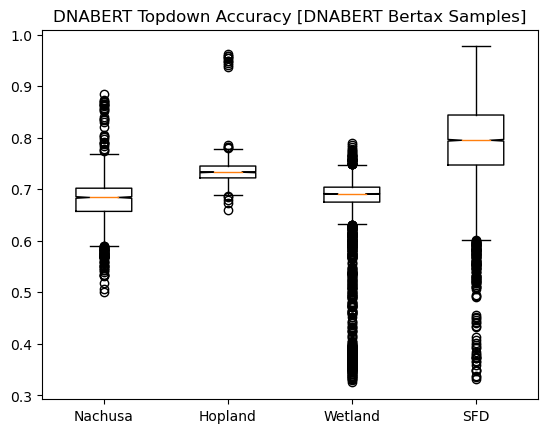

In [34]:
labels = list(dataset_accuracies.keys())
accuracies = list(dataset_accuracies.values())
plt.title(f"DNABERT Topdown Accuracy [DNABERT {model_type} Samples]")
plt.boxplot(accuracies, labels=labels, notch=True)
plt.show()

In [111]:
print("DNABERT (TopDown Predictions):")
print("Evaluated across 210 Samples (10 subsamples of 1,000 sequences each):")
print("Metrics are computed across 2,100 subsamples.")
print(f"Min: {np.min(accuracies):%}")
print(f"Mean: {np.mean(accuracies):%}")
print(f"Max: {np.max(accuracies):%}")
print(f"STD: {np.std(accuracies):%}")

DNABERT (TopDown Predictions):
Evaluated across 210 Samples (10 subsamples of 1,000 sequences each):
Metrics are computed across 2,100 subsamples.
Min: 70.800000%
Mean: 76.501286%
Max: 91.700000%
STD: 2.289634%


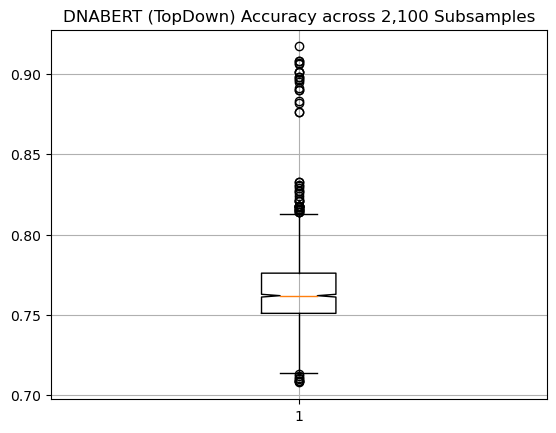

In [112]:
plt.boxplot(accuracies, notch=True)
plt.title("DNABERT (TopDown) Accuracy across 2,100 Subsamples")
plt.grid()

In [113]:
np.savetxt("./logs/dnabert_taxonomy_topdown_accuracy.txt", accuracies)